In [2]:
# General
import os
import datetime
import time

# Tweets
import tweepy
import requests as req

# Pydata
import pandas as pd
from pandas import ExcelWriter
from pandas_datareader import data, wb
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.graphics.regressionplots as sgr
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt

#Natural Language Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

%matplotlib inline

In [3]:
### Define time horizon for data pull
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime.now()

In [4]:
### Data pull for all indicators
# # VIX Indicator
VIIX = data.DataReader("VIIX", 'iex', start, end)

# # VT Worldmarket
VT = data.DataReader("VT", 'iex', start, end)

# # STPP Bond yield inversion curve indicator
STPP = data.DataReader("STPP", 'iex', start, end)

# # SPYV S&P 500 index
SPYV = data.DataReader("SPYV", 'iex', start, end)

In [5]:
### Merging Stock Data Frames
stock_values= data.DataReader(['VIIX', 'VT', 'STPP', 'SPYV'],'iex', start, end)
stock_values.tail()

Attributes   open                            high                           \
Symbols      SPYV     STPP   VIIX     VT     SPYV     STPP   VIIX       VT   
date                                                                         
2019-03-08  29.47  29.7400  14.40  71.24  29.6600  29.7400  14.62  71.5800   
2019-03-11  29.78      NaN  13.79  71.77  30.0900      NaN  13.79  72.5100   
2019-03-12  30.14  25.6626  12.90  72.62  30.2600  25.6626  12.95  72.7790   
2019-03-13  30.28      NaN  12.59  72.92  30.4712      NaN  12.64  73.2666   
2019-03-14  30.41  26.9900  12.52  73.08  30.4650  27.0050  12.54  73.1200   

Attributes    low                            close                         \
Symbols      SPYV     STPP     VIIX      VT   SPYV     STPP   VIIX     VT   
date                                                                        
2019-03-08  29.43  29.0000  14.0500  71.085  29.66  29.4500  14.05  71.53   
2019-03-11  29.76      NaN  12.9800  71.750  30.07      NaN  13.02  72.49   
2019-03-12  30.13  25.6626  12.6462  72.570  30.17  25.6626  12.66  72.67   
2019-03-13  30.26      NaN  12.4300  72.850  30.36  25.6626  12.53  73.09   
2019-03-14  30.34  26.9900  12.2873  72.880  30.39  27.0050  12.33  73.00   

Attributes     volume                              
Symbols          SPYV   STPP      VIIX         VT  
date                                               
2019-03-08   561024.0  671.0  154367.0  1890293.0  
2019-03-11  1104974.0    NaN  189692.0  1327225.0  
2019-03-12  2050047.0  100.0  180720.0  7052739.0  
2019-03-13   465695.0   71.0   96330.0  2184861.0  
2019-03-14   374328.0  505.0   83402.0  1487806.0

In [6]:
returns = stock_values.close.pct_change()
returns.dropna
returns.tail()

Symbols,SPYV,STPP,VIIX,VT
date,,,,
2019-03-08,-0.000337,0.051786,0.006447,-0.002649
2019-03-11,0.013823,0.000000,-0.073310,0.013421
2019-03-12,0.003326,-0.128604,-0.027650,0.002483
2019-03-13,0.006298,0.000000,-0.010269,0.005780
2019-03-14,0.000988,0.052310,-0.015962,-0.001231


In [7]:
#returns.reset_index(level='Symbols',col_level=1) standardizes dataframe structure to make merging with Twitter score easier
returns.reset_index(level=0, inplace=True)
returns.rename(columns={'index': 'date'})
returns.dropna()
returns.tail()

Symbols,date,SPYV,STPP,VIIX,VT
1051,2019-03-08,-0.000337,0.051786,0.006447,-0.002649
1052,2019-03-11,0.013823,0.000000,-0.073310,0.013421
1053,2019-03-12,0.003326,-0.128604,-0.027650,0.002483
1054,2019-03-13,0.006298,0.000000,-0.010269,0.005780
1055,2019-03-14,0.000988,0.052310,-0.015962,-0.001231


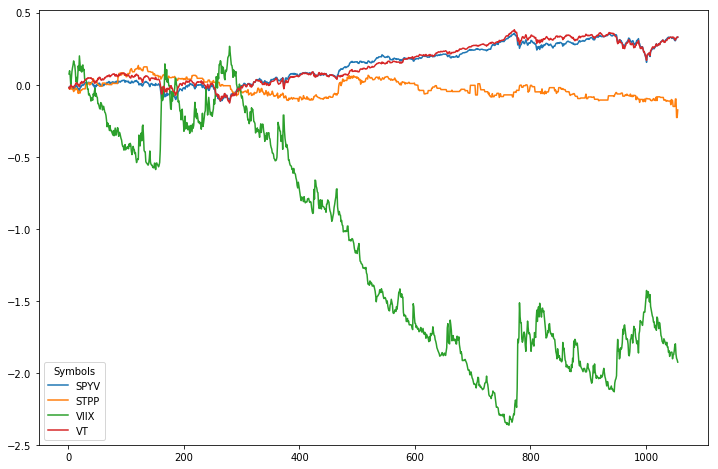

In [8]:
returns.cumsum().plot(figsize=(12,8))


In [9]:
###Twitter key access and data handling block using tweepy authorization

# App called RecessionScare hosted on @MaxLechner2
consumer_key = 'zcxYdXZRue1dHYQCrObnZw3Ok' # (API key)
consumer_secret = 'zOdXXdpPI8yzC0Diy2OOvon8Y3P7GXltyGCzgudFQ7GLxkqixI' # (API secret key)
access_token = '1068143141570646023-KMywNcJCzv9uPxWsrwF8imWYxDmHrt' # (Access token)
access_token_secret = 'DzL3M7eVobmHcz2rd9G9cyhrou5a7E1o4cWQ5rrzeNUBH' # (Access token secret)

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

In [10]:
### Build for pulling out Twitter information from user_id list and analyzing using VADER tool  
### Compound score per each tweet assigned in column with date and tweet
def tweet_analyzer(user_id):
    tweet_txt=[]
    compound_tweet=[]
    tweet_date=[]
    public_tweets = []
    
    for y in range(len(user_id)):
            for x in range(0, 40):
                try:
                    public_tweets += api.user_timeline(str(user_id[y]), page=x)
                except:
                    pass
            for tweet in public_tweets:
                # Run Vader Analysis on each tweet
                results = analyzer.polarity_scores(tweet["text"])
                compound = results["compound"]
                date=tweet['created_at']
                txt=tweet['text']
                # saving values
                compound_tweet.append(compound)
                tweet_txt.append(txt)
                tweet_date.append(date)
            results = {
                "date":tweet_date,
                "Tweet":tweet_txt,
                "Compound Score": compound_tweet
                }
    return results


In [11]:
### Twitter ID list for key analysts across twittersphere and calling tweet analyzer function
user_id = ['cnbc', 'benzinga', 'stocktwits', 'breakoutstocks', 'bespokeinvest', 'WSJMarkets', 'stephanie_link', 'nytimesbusiness', 
           'IBDinvestors', 'TheStalwart', 'MorganStanley', 'MohamedEl-Erian', 'SeekingAlpha', 
           'SimsOnFinance','EPBResearch','ReformedBroker', 'StLouisFed', 'SallieKrawcheck','benthompson','TruthGundlach',
           'LizAnnSonders','morganhouselFXCM', 'MarkYusko', 'CiovaccoCapital', 'Greenbackd', 'TMFJMo', 'CitronResearch', 
           'MebFaber', 'AswathDamodaran', 'financialsamura', 'USNewsInvesting', 'howardrgold',
           'DCBorthwick', 'DailyFXTeam', 'zerohedge', 'russian_market', 'MarketWatch', 'KeithMcCullough']
analyzedResults = tweet_analyzer(user_id) 

In [12]:
###Creating dataframe for twitter compound score & standardizing date
compoundScore_df=pd.DataFrame(analyzedResults)
for date in compoundScore_df['date']:
    dt=datetime.datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y")
daily_dt=pd.to_datetime(compoundScore_df['date']).dt.to_period('d')
compoundScore_df["date"]=daily_dt

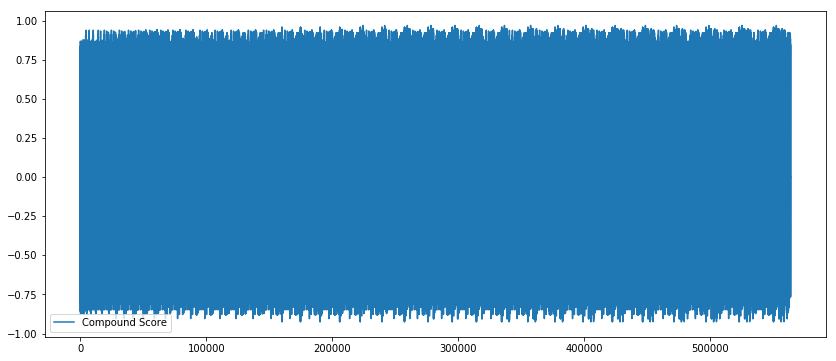

In [13]:
compoundScore_df.head()
compoundScore_df.plot(figsize=(14,6))

In [28]:
### Pulling Data Into Excel 
compoundScore_df.to_excel("TwitterScore.xlsx")

In [14]:
### Function to filter irrelevant tweets from the dataset
# def check_key_words(x):
#     key_words = pd.read_csv("SPY500.csv")
#     x_list = x.split()
#     for key_word in key_words:
#         if key_word in x_list:
#             return True
#     return False

In [15]:
### Passes compoundScore_df through check_key_words 
# filter_df = compoundScore_df[compoundScore_df['Tweet'].apply(check_key_words)]
# filter_df.head()

In [16]:
# filter_df
# filter_df.plot(figsize=(14,6))

In [18]:
### calculates daily mean or standard deviation.  Testing must be conducted to determine best use of data ie(mean, variance, etc.)
Daily_avg_mk=compoundScore_df.groupby('date')['Compound Score'].mean()
Daily_dataframe_mk=pd.DataFrame({'mean':Daily_avg_mk})
Daily_df_mk=Daily_dataframe_mk.reset_index()
Daily_df_mk=Daily_df_mk.sort_values('date', ascending=True)
Daily_df_mk.head()


           date      mean
0    2011-01-18  0.790600
1    2011-01-24  0.000000
2    2011-04-14 -0.673900
3    2011-04-26  0.000000
4    2011-04-27  0.700300
5    2011-08-03  0.000000
6    2011-08-04 -0.128000
7    2011-08-08 -0.153100
8    2011-08-16 -0.446600
9    2011-08-19  0.000000
10   2011-08-22 -0.318200
11   2011-09-06 -0.585900
12   2011-09-21 -0.666600
13   2011-12-05  0.318200
14   2011-12-07 -0.585900
15   2012-03-13  0.000000
16   2012-03-26  0.265100
17   2012-05-07  0.624900
18   2012-06-13 -0.743000
19   2012-08-08  0.000000
20   2012-08-30  0.855500
21   2012-08-31  0.000000
22   2012-09-04  0.557400
23   2012-09-11  0.000000
24   2012-09-19 -0.401900
25   2012-09-25 -0.797000
26   2012-10-12  0.476700
27   2012-10-17 -0.574800
28   2012-11-02  0.000000
29   2012-12-04 -0.542300
...         ...       ...
1297 2019-02-14  0.087797
1298 2019-02-15  0.120602
1299 2019-02-16  0.182245
1300 2019-02-17  0.138446
1301 2019-02-18  0.103226
1302 2019-02-19  0.124418
1303 2019-02

In [19]:
### Merging stock and twitter dataframes
returns['date'] = returns['date'].astype('|S')
Daily_df_mk['date'] = Daily_df_mk['date'].astype('|S')
combined_df=pd.merge(returns, Daily_df_mk, on='date',how='left')
combined_df.tail()

,date,SPYV,STPP,VIIX,VT,mean
1051,b'2019-03-08',-0.000337,0.051786,0.006447,-0.002649,0.116096
1052,b'2019-03-11',0.013823,0.000000,-0.073310,0.013421,0.091046
1053,b'2019-03-12',0.003326,-0.128604,-0.027650,0.002483,0.048782
1054,b'2019-03-13',0.006298,0.000000,-0.010269,0.005780,0.083760
1055,b'2019-03-14',0.000988,0.052310,-0.015962,-0.001231,0.057849


In [21]:
# ### reformatting mean as a pct change
# combined_df.mean.pct_change()
# combined_df.tail()

In [27]:
### downloading the data to excel
combined_df.to_excel("VolatilityRegression.xlsx", engine='xlsxwriter')

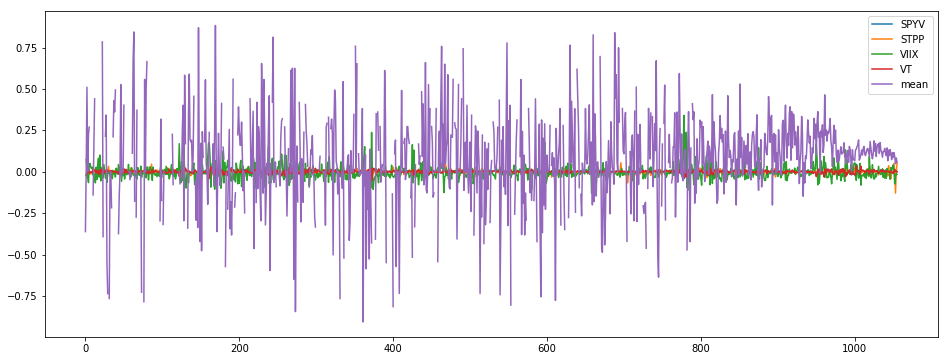

In [25]:
combined_df.plot(figsize=(16,6))

Model1: Bond Inversion Curve Summary Statistics                             OLS Regression Results                            
Dep. Variable:                   SPYV   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.532
Date:                Thu, 14 Mar 2019   Prob (F-statistic):            0.00356
Time:                        21:38:22   Log-Likelihood:                 3562.3
No. Observations:                1055   AIC:                            -7121.
Df Residuals:                    1053   BIC:                            -7111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

Model5: Multivariable World Market Summary Statistics                             OLS Regression Results                            
Dep. Variable:                     VT   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1623.
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:38:23   Log-Likelihood:                 3916.5
No. Observations:                 894   AIC:                            -7823.
Df Residuals:                     889   BIC:                            -7799.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Text(0.5, 1.0, 'Linear Regression Model 6')

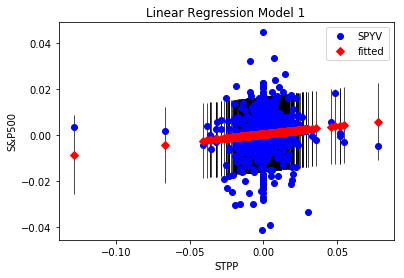

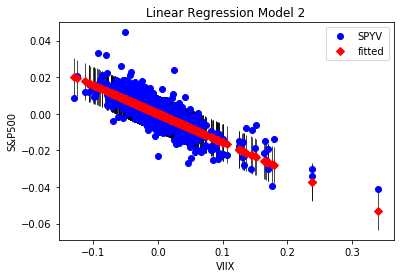

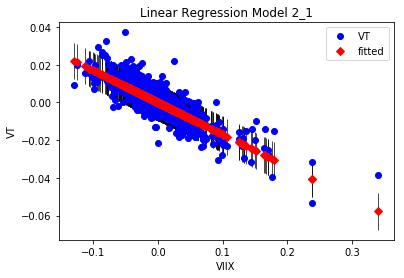

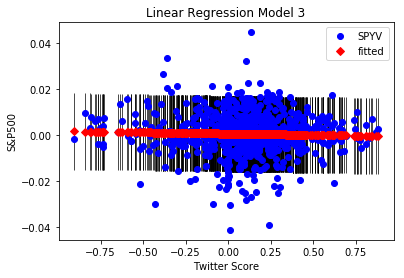

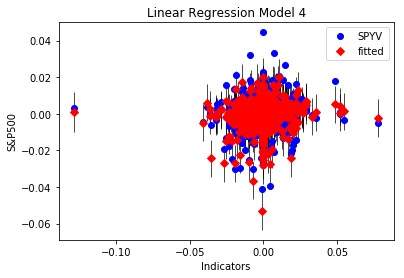

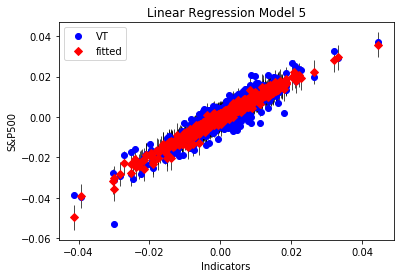

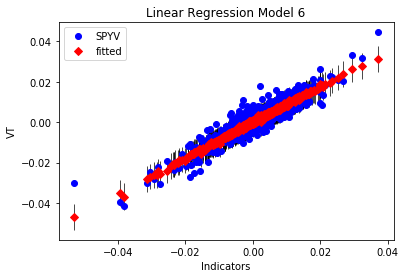

In [26]:
### Simple Linear regressions to test data
model1 = ols('SPYV ~ STPP',data=combined_df).fit()
model2 = ols('SPYV ~ VIIX',data=combined_df).fit()
model2_1 = ols('VT ~ VIIX',data=combined_df).fit()
model3 = ols('SPYV ~ mean',data=combined_df).fit()
model4 = ols('SPYV ~ STPP + VIIX + mean',data=combined_df).fit()
model5 = ols('VT ~ SPYV + STPP + VIIX + mean',data=combined_df).fit()
model6 = ols('SPYV ~ VT + STPP + VIIX + mean',data=combined_df).fit()
print("Model1: Bond Inversion Curve Summary Statistics",  model1.summary())
print("Model2: VIIX Prediction Summary Statistics SP500", model2.summary())
print("Model2_1: VIIX Prediction Summary Statistics VT", model2_1.summary())
print("Model3: Twitter Average Sentiment Summary Statistics", model3.summary())
print("Model4: Combined Model Summary Statistics", model4.summary())
print("Model5: Multivariable World Market Summary Statistics", model5.summary())
print("Model6: Multivariable S&P 500 Summary Statistics", model6.summary())

fig1, ax = plt.subplots()
m1= sgr.plot_fit(model1, 1 , ax=ax)
ax.set_ylabel("S&P500")
ax.set_xlabel("STPP")
ax.set_title("Linear Regression Model 1")

fig, ax = plt.subplots()
m2= sgr.plot_fit(model2, 1 , ax=ax)
ax.set_ylabel("S&P500")
ax.set_xlabel("VIIX")
ax.set_title("Linear Regression Model 2")

fig, ax = plt.subplots()
m2= sgr.plot_fit(model2_1, 1 , ax=ax)
ax.set_ylabel("VT")
ax.set_xlabel("VIIX")
ax.set_title("Linear Regression Model 2_1")

fig, ax = plt.subplots()
m3= sgr.plot_fit(model3, 1 , ax=ax)
ax.set_ylabel("S&P500")
ax.set_xlabel("Twitter Score")
ax.set_title("Linear Regression Model 3")

fig, ax = plt.subplots()
m4= sgr.plot_fit(model4, 1 , ax=ax)
ax.set_ylabel("S&P500")
ax.set_xlabel("Indicators")
ax.set_title("Linear Regression Model 4")

fig, ax = plt.subplots()
m5= sgr.plot_fit(model5, 1 , ax=ax)
ax.set_ylabel("S&P500")
ax.set_xlabel("Indicators")
ax.set_title("Linear Regression Model 5")

fig, ax = plt.subplots()
m6= sgr.plot_fit(model6, 1 , ax=ax)
ax.set_ylabel("VT")
ax.set_xlabel("Indicators")
ax.set_title("Linear Regression Model 6")

In [20]:
### Manually splitting data to have a training set twice as large as testing
model_train = combined_df[:-300]
model_test =combined_df[-300:]
X = combined_df.loc[:,:"mean"]
X_train = X[:-300]
X_test = X[-300:]
Y_train = combined_df.SPYV[:-300]
Y_test = combined_df.SPYV[-300:]
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(754, 6)
(300, 6)
(754,)
(300,)


Mean of S&P500 prediction model:  0.0018302084025433717
Standard deviation of S&P500 predicton model 6.330463342956206e-05


Text(0.5, 0, 'Difference With Tested Data')

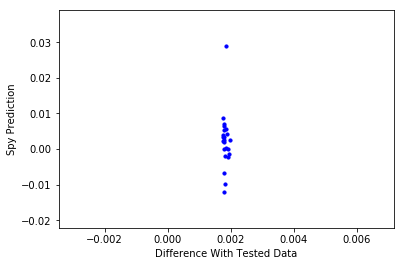

In [21]:
### Using split data set to verify the integrity of the training model
m = ols('SPYV ~ VT + STPP + VIIX + mean',model_train).fit()
spy_pred = m.predict(model_test)
print("Mean of S&P500 prediction model: ", spy_pred.mean())
print("Standard deviation of S&P500 predicton model", spy_pred.std())
plt.scatter(spy_pred, spy_pred - Y_test, c='b', s =10)
plt.ylabel("Spy Prediction")
plt.xlabel("Difference With Tested Data")
